In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import comet_ml
experiment = comet_ml.Experiment(project_name="2019nn_beer")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/aeryen/2019nn-beer/08e40a2cc6344488acf283269a92eb31



In [3]:
# %%
from fastai.text import *
from data_helpers.Data import *
from fastai.text.transform import *

In [4]:
hyper_params = {
    "max_sequence_length": 20*70,
    "batch_size": 32,
    "num_epochs1": 12,
    "num_epochs2": 15,
    "num_aspect": 5,
    "num_rating": 5,
}

In [5]:
experiment.log_parameters(hyper_params)

# Load LM Databunch and LM Learner

In [6]:
# lm_db = load_data("./data/", "hotel_lm_databunch.1001")
# lm_learn = language_model_learner(lm_db, AWD_LSTM)
# lm_learn = lm_learn.load("lang_model_hotel")

In [7]:
# lm_learn.save_encoder('lang_model_hotel_enc')

In [6]:
cls_db = load_data("./data/", "beer_clas_databunch_rint.TraValTes")
cls_db.batch_size=hyper_params["batch_size"]
cls_db.batch_size

32

# Tools

### Sentence Feature Combo Pooling (1200)

In [7]:
def pool_combo(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    max_pool = output[start:end, :].max(dim=0)[0]
    x = torch.cat([output[-1,:], max_pool, avg_pool], 0)
    return x

def sentence_pool_1200(outputs, mask, p_index):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    seq_max = output.size(1)
    doc_start = mask.int().sum(dim=1)
    
    batch = []
    for doci in range(0,output.shape[0]):
        pi = p_index[doci,:].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range( len(pi) ):
            if senti==0:
                doc.append( pool_combo(output[doci,:,:], doc_start[doci], pi[senti]) )
            else:
                doc.append( pool_combo(output[doci,:,:], pi[senti-1]+1, pi[senti]) )
            
        batch.append( torch.stack(doc, 0) )

    return batch

def sentence_pool_400(outputs, mask, p_index):
    output = outputs[-1]
    
    batch = []
    for doci in range(0,output.shape[0]):
        doc = output[doci,p_index[doci,:],:]
        batch.append( doc )

    return batch

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

## DEFINE MODEL

In [8]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder init")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+self.bptt, sl)] == self.period_index )

                
        # print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
        # print(n_sent)
        
        # print("locating period marks")
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

# CLS 02

In [8]:
# experiment.add_tag("CLAS02")
# experiment.add_tag("ATTIND400")

# ATTENTIONAL AVERAGING, INDEPENDENT SENTI OUT

class Cls02ATT400(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp + 1
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0.1, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=None )
        self.aspect = nn.Sequential(*mod_layers)
        
        self.senti_base = nn.Sequential(*bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) )
        
        self.s0 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s1 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s2 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s3 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s4 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s5 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.s6 = nn.Sequential(* bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) )
        self.sentiments = []
        self.sentiments.append( self.s0 )
        self.sentiments.append( self.s1 )
        self.sentiments.append( self.s2 )
        self.sentiments.append( self.s3 )
        self.sentiments.append( self.s4 )
        self.sentiments.append( self.s5 )
        self.sentiments.append( self.s6 )

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        batch = sentence_pool_400(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)          # [n_sentence, emb400]
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect6]

        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), allsent_emb.unsqueeze(1))  # [319, 7, 400]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 400]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 7]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                                 # [1, 7, 400]
#             doc_emb_max = torch.max(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)[0] # [1, 7, 400]
#             all_doc_emb.append( torch.cat( [doc_emb_avg, doc_emb_max], dim=2 ) )
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 1200]
        
        result_senti_base = self.senti_base( all_doc_emb.view(-1, 400) ) # [batch*asp, 50]
        result_senti_base = result_senti_base.view(-1, self.n_asp, 50)    # [batch, asp, 50]
        
        result_senti = [ self.sentiments[aspi]( result_senti_base[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

In [9]:
experiment.add_tag("CLAS02")
experiment.add_tag("FULLIND400")

# ATTENTIONAL AVERAGING, COMPLETELY INDEPENDENT SENTI OUT

class Cls02ATT400(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp + 1
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0.1, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
#         self.senti_base = nn.Sequential(*bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) )
        self.s0 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.s1 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.s2 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.s3 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.s4 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.s5 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
#         self.s6 = nn.Sequential(* (bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) + 
#                                    bn_drop_lin( 50, self.n_rat, p=0.1, actn=None ) ) )
        self.sentiments = []
        self.sentiments.append( self.s0 )
        self.sentiments.append( self.s1 )
        self.sentiments.append( self.s2 )
        self.sentiments.append( self.s3 )
        self.sentiments.append( self.s4 )
        self.sentiments.append( self.s5 )
#         self.sentiments.append( self.s6 )

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        batch = sentence_pool_400(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)          # [n_sentence, emb400]
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect6]

        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), allsent_emb.unsqueeze(1))  # [319, 7, 400]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 400]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 7]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                                 # [1, 7, 400]
#             doc_emb_max = torch.max(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)[0] # [1, 7, 400]
#             all_doc_emb.append( torch.cat( [doc_emb_avg, doc_emb_max], dim=2 ) )
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 400]
        
#         result_senti_base = self.senti_base( all_doc_emb.view(-1, 400) ) # [batch*asp, 50]
#         result_senti_base = result_senti_base.view(-1, self.n_asp, 50)    # [batch, asp, 50]
        
        result_senti = [ self.sentiments[aspi]( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

# Building Learner

In [10]:
def get_text_classifier(arch:Callable, vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    print("CUSTOM DEFINED CLASSIFIER")
    meta = text.learner._model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = SentenceEncoder(bptt, max_len, arch(vocab_sz, **config), vocab, pad_idx=pad_idx)
    cls_layer = Cls02ATT400(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"], layers=layers, drops=ps)
    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

In [11]:
def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

## Classification loss and metrics

In [12]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target, nasp=5):
        target = target.long()
        loss = 0
        
        for i in range(nasp):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

In [13]:
def multi_acc(preds, targs, nasp=hyper_params["num_aspect"], nrat=5):
    preds = preds[:,0:nasp,:]
    preds = preds.contiguous().view(-1, nrat)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [14]:
def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc

In [15]:
def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

## create the objects

In [16]:
macc=[get_clas_acc(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]): macc[ai].__name__ = "clas_acc_"+str(ai)
mmse=[get_clas_mse(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]): mmse[ai].__name__ = "clas_mse_"+str(ai)

In [17]:
mloss = MultiLabelCEL()
cls_learn = text_classifier_learner(cls_db, AWD_LSTM,
                                    drop_mult=1.2,
                                    loss_func=mloss,
                                    metrics=[multi_acc]+macc+mmse,
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"])

CUSTOM DEFINED CLASSIFIER
Encoder init
CLS init
Num Aspect: 5
Num Rating: 5
FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)


In [18]:
from fastai.callbacks.tracker import TrackerCallback

In [19]:
def fast_validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    
    with torch.no_grad():
        val_losses,nums = [],[]

        for xb,yb in dl:            
            out = model(xb)[0]
            val_loss = loss_func(out, yb)
            val_loss = val_loss.detach().cpu()
            
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if n_batch and (len(nums)>=n_batch): break
            
        nums = np.array(nums, dtype=np.float32)
        return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()


In [20]:
class SaveBestStepModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:int=50, name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every, self.name = every, name
        self.step = 0
        self.records = []
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.step = 0
        
    def on_batch_end(self, **kwargs:Any)->None:
        self.step += 1

        if self.step % self.every == 0:
            self.learn.model.eval()
            current = fast_validate(self.learn.model, self.learn.data.valid_dl, self.learn.loss_func, n_batch=50)
            self.learn.model.train()
            
            if isinstance(current, Tensor): current = current.cpu()
            self.records.append(current)
            
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at step {self.step} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        pass
#         "Load the best model."
#         if self.every=="improvement" and os.path.isfile(self.path/self.model_dir/f'{self.name}.pth'):
#             self.learn.load(f'{self.name}', purge=False)
            
    

In [21]:
cls_learn.callback_fns = [cls_learn.callback_fns[0]]

In [22]:
cls_learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [23]:
cls_learn.callback_fns += [ partial(SaveBestStepModel, monitor="valid_loss", mode="min", every=100, name='beer.clas.attfullind400.best.learner') ]

In [24]:
_ = cls_learn.load_encoder('lm_enc_beer.1115')

FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=6, bias=True)
      (7): Soft

# Train log

## CLAS 02

In [ ]:
# good loss
with experiment.train():
    cls_learn.fit_one_cycle( 6 , max_lr=slice(1e-3,2e-2))

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time


Better model found at step 100 with valid_loss value: 5.984330654144287.
Better model found at step 200 with valid_loss value: 5.288189888000488.
Better model found at step 300 with valid_loss value: 4.8232245445251465.
Better model found at step 400 with valid_loss value: 4.622148036956787.
Better model found at step 500 with valid_loss value: 4.59514045715332.
Better model found at step 800 with valid_loss value: 4.553602695465088.


In [ ]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [134]:
cls_learn.save('beer.clas.attfullind400.1.learner')

In [26]:
cls_learn.load('beer.clas.attfullind400.1.learner')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Unexpected key(s) in state_dict: "1.s6.0.weight", "1.s6.0.bias", "1.s6.0.running_mean", "1.s6.0.running_var", "1.s6.0.num_batches_tracked", "1.s6.2.weight", "1.s6.2.bias", "1.s6.4.weight", "1.s6.4.bias", "1.s6.4.running_mean", "1.s6.4.running_var", "1.s6.4.num_batches_tracked", "1.s6.6.weight", "1.s6.6.bias". 

In [135]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02ATT400(
    (aspect): Sequential(
      (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=400, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=6, bias=True)
   

In [28]:
# FULL INDIPENDENT
with experiment.train():
    cls_learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.738288,4.251144,0.611960,0.608086,0.594163,0.648875,0.603624,0.605052,0.493752,0.456801,0.437701,0.465816,0.478133,04:33
1,4.562331,4.173386,0.619475,0.611746,0.603088,0.652624,0.613263,0.616655,0.497412,0.447965,0.422171,0.461264,0.459032,04:36
2,4.515416,4.101168,0.624813,0.620582,0.597911,0.659407,0.625402,0.620760,0.478311,0.476794,0.407890,0.445823,0.458943,04:28
3,4.446592,4.060063,0.630400,0.625312,0.609693,0.664941,0.626473,0.625580,0.475634,0.441449,0.417351,0.441449,0.440378,04:37
4,4.402438,4.020736,0.632988,0.624420,0.611924,0.668690,0.628972,0.630935,0.475991,0.456712,0.406462,0.434577,0.444930,04:37
5,4.302449,3.982461,0.637790,0.634416,0.615494,0.673152,0.635398,0.630489,0.447162,0.433417,0.384059,0.418154,0.448768,04:39
6,4.176979,3.955843,0.640682,0.636201,0.614780,0.676990,0.635844,0.639593,0.442342,0.443502,0.378615,0.424134,0.416905,04:43
7,4.076322,3.947469,0.642681,0.635577,0.617280,0.677347,0.642806,0.640396,0.460371,0.438772,0.384595,0.412710,0.425473,04:37
8,4.077200,3.937829,0.642199,0.634149,0.618261,0.678240,0.639057,0.641289,0.453409,0.444573,0.373438,0.414227,0.417619,04:35
9,3.976473,3.949420,0.642502,0.636648,0.619868,0.673688,0.641824,0.640486,0.456623,0.438950,0.389772,0.428418,0.417886,04:47


In [ ]:
# FULL INDIPENDENT, 1.2 DROPOUT
with experiment.train():
    cls_learn.fit_one_cycle(18)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.906426,4.866243,0.545073,0.537040,0.533113,0.572206,0.540878,0.542128,0.659407,0.559711,0.605141,0.578722,0.604070,06:47
1,4.844094,4.724708,0.562370,0.559622,0.546323,0.591128,0.560603,0.554177,0.610586,0.548019,0.570154,0.563013,0.594520,06:34
2,4.703526,4.702122,0.563245,0.555694,0.547751,0.591128,0.567030,0.554623,0.647447,0.558372,0.573277,0.554088,0.605230,06:57
3,4.599808,4.521493,0.583077,0.576312,0.565423,0.612281,0.587558,0.573813,0.591307,0.538558,0.527401,0.514548,0.546323,07:00


Better model found at step 100 with valid_loss value: 4.400759696960449.
Better model found at step 300 with valid_loss value: 4.392011642456055.
Better model found at step 600 with valid_loss value: 4.3827714920043945.
Better model found at step 700 with valid_loss value: 4.344567775726318.
Better model found at step 1500 with valid_loss value: 4.328266143798828.
Better model found at step 2100 with valid_loss value: 4.293142795562744.
Better model found at step 3100 with valid_loss value: 4.2860188484191895.
Better model found at step 3300 with valid_loss value: 4.259410381317139.
Better model found at step 3500 with valid_loss value: 4.2545857429504395.
Better model found at step 4800 with valid_loss value: 4.232550144195557.
Better model found at step 4900 with valid_loss value: 4.215993404388428.
Better model found at step 5400 with valid_loss value: 4.214898109436035.
Better model found at step 5500 with valid_loss value: 4.202560901641846.
Better model found at step 5700 with va

{'web': 'https://www.comet.ml/api/image/download?imageId=566a53d3bfd947e8947da80251ae9f78&experimentKey=3cbb025fbcf1445990d612bcae8d241f',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=566a53d3bfd947e8947da80251ae9f78&experimentKey=3cbb025fbcf1445990d612bcae8d241f',
 'imageId': '566a53d3bfd947e8947da80251ae9f78'}

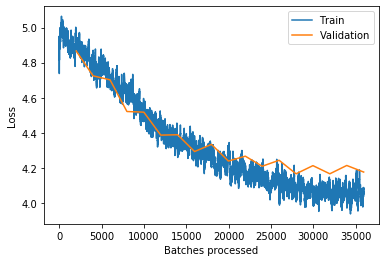

In [137]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [138]:
cls_learn.save('beer.clas.attfullind400.2.learner')

In [20]:
cls_learn.load('beer.clas.attfullind400.2.learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (63909 items)
x: TextList
xxbos a lot of foam xxperiod xxmaj but a lot xxperiod xxmaj in the smell some banana , and then lactic and tart xxperiod xxmaj not a good start xxperiod xxmaj quite dark orange in color , with a lively carbonation ( now visible , under the foam ) xxperiod xxmaj again tending to lactic sourness xxperiod xxmaj same for the taste xxperiod xxmaj with some yeast and banana xxperiod,xxbos xxmaj almost totally black xxperiod xxmaj beige foam , quite compact , not bad xxperiod xxmaj light smell , just a bit of roast , and some hop xxperiod a bit too light xxperiod xxmaj the taste is light oo , and drinkable , with some malt , roast , hints of coffee xxperiod xxmaj nothing exceptional , but after all drinkable and pleasant xxperiod xxmaj light to average body xxperiod xxmaj in the aftertaste some dust , xxunk roast , hint of caramel , and a bit of bitterness xxperiod xxmaj no defect , drinkable , not bad xxperiod,xxb

# FINISH EXPR

In [58]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/aeryen/2019nn-beer/ba8df291ce4b4b7987213dd7d905cc85
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01 [1315]       : (0.0, 15.4)
COMET INFO:     sys.cpu.percent.02 [1315]       : (0.0, 15.2)
COMET INFO:     sys.cpu.percent.03 [1315]       : (0.0, 16.1)
COMET INFO:     sys.cpu.percent.04 [1315]       : (0.0, 17.0)
COMET INFO:     sys.cpu.percent.05 [1315]       : (0.0, 16.0)
COMET INFO:     sys.cpu.percent.06 [1315]       : (0.0, 15.8)
COMET INFO:     sys.cpu.percent.07 [1315]       : (0.0, 16.3)
COMET INFO:     sys.cpu.percent.08 [1315]       : (0.0, 16.0)
COMET INFO:     sys.cpu.percent.09 [1315]       : (0.0, 15.5)
COMET INFO:     sys.cpu.percent.10 [1315]       : (0.0, 18.6)
COMET INFO:     sys.cpu.percent.11 [1315]       : (0.1, 21.0)
COMET INFO:     sys.cpu.percent.12 [1315]       : (0.0, 15.1)
COMET INFO:     sy

# Load Test Data

In [21]:
sent_num_file = ["train.count", "test.count"]
rating_file = ["train.rating", "test.rating"]
content_file = ["train.txt", "test.txt"]

dataset_dir = "./data/beer_100k/"

In [22]:
def concat_to_doc(sent_list, sent_count):
    start_index = 0
    docs = []
    for s in sent_count:
#         doc = " xxPERIOD ".join(sent_list[start_index:start_index + s])
#         doc = doc + " xxPERIOD "
        docs.append(sent_list[start_index:start_index + s])
        start_index = start_index + s
    return docs

In [23]:
# TRAIN_DATA = 0
TEST_DATA = 1

In [24]:
# # Load Count
sent_count_test = list(open(dataset_dir + sent_num_file[TEST_DATA], "r").readlines())
sent_count_test = [int(s) for s in sent_count_test if (len(s) > 0 and s != "\n")]
print( sent_count_test[0:5] )

# Load Ratings
aspect_rating_test = list(open(dataset_dir + rating_file[TEST_DATA], "r").readlines())
aspect_rating_test = [s for s in aspect_rating_test if (len(s) > 0 and s != "\n")]

aspect_rating_test = [s.split(" ") for s in aspect_rating_test]
aspect_rating_test = np.array(aspect_rating_test)[:, :]
aspect_rating_test = aspect_rating_test.astype(np.float) - 1
aspect_rating_test = np.rint(aspect_rating_test).astype(int)  # ROUND TO INTEGER =================
aspect_rating_test = pd.DataFrame(aspect_rating_test)
print( aspect_rating_test.head() )

# Load Sents
sents_test = list(open(dataset_dir + content_file[TEST_DATA], "r").readlines())
sents_test = [s.strip() for s in sents_test]
sents_test = [s[:-1] for s in sents_test if s.endswith(".")]
print( sents_test[0:5] )

# Sents to Doc
docs_test = concat_to_doc(sents_test, sent_count_test)
docs_test = pd.DataFrame({doc:docs_test})

[13, 12, 7, 9, 6]
   0  1  2  3  4
0  3  3  4  3  4
1  2  2  2  2  2
2  3  3  3  2  3
3  3  2  2  2  4
4  2  2  2  2  2
['According to the website, the style for the Caldera Cauldron changes every year', "The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back)", 'In any event', 'at the Horse Brass yesterday', 'The beer pours an orange copper color with good head retention and lacing']


In [25]:
df_test = pd.concat( [aspect_rating_test, docs_test], axis=1, ignore_index=True )
df_test.head()

,0,1,2,3,4,5
0,3,3,4,3,4,"[According to the website, the style for the C..."
1,2,2,2,2,2,"[Poured from the bottle into a Chimay goblet, ..."
2,3,3,3,2,3,"[Notes from 6/24, A: Bright golden glowing bee..."
3,3,2,2,2,4,"[22 oz, bomber,, A: Pours a clear yellow with ..."
4,2,2,2,2,2,"[Brown in color, somewhere between a porter an..."


# Test output

In [26]:
def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc
def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

In [27]:
def get_preds(self,
              ds_type:DatasetType,
              activ:nn.Module=None,
              with_loss:bool=False,
              n_batch:Optional[int]=None,
              pbar:Optional[PBar]=None,
              ordered:bool=False) -> List[Tensor]:
    "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
    self.model.reset()
    if ordered: np.random.seed(42)
    
    with torch.no_grad():
        outs = []
        asps = []
        for xb,yb in progress_bar(cls_learn.dl(ds_type)):
            out,raw_enc,enc,asp = cls_learn.model(xb)
            outs.append(out)
            for doc in asp:
                asps.append( to_float(doc.cpu()))

    outs = to_float(torch.cat(outs).cpu())
    
    if ordered and hasattr(self.dl(ds_type), 'sampler'):
        np.random.seed(42)
        sampler = [i for i in self.dl(ds_type).sampler]
        reverse_sampler = np.argsort(sampler)
        
        outs = outs[reverse_sampler]
        asps = [asps[i] for i in reverse_sampler]
    return (outs,asps)

In [28]:
outs,asps = get_preds(self=cls_learn, ds_type=DatasetType.Test, ordered=True)

In [29]:
outs.shape

torch.Size([24884, 6, 5])

In [30]:
target = torch.tensor( aspect_rating_test.values )
target

tensor([[3, 3, 4, 3, 4],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 2, 3],
        ...,
        [4, 2, 4, 3, 4],
        [2, 2, 1, 0, 3],
        [3, 2, 4, 2, 4]])

In [31]:
mloss = MultiLabelCEL()
mloss.forward(outs, target)

tensor(4.3240)

In [32]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_acc(ai)(outs, target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.598738,0.591786,0.641416,0.610272,0.606052


In [47]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_mse(ai)(outs, target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.453062,0.447597,0.390452,0.42879,0.443056


# Visualize classification output

In [57]:
asp_inc_overall = True
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["Overall", "Appearance", "Taste", "Palate", "Aroma"]
for i in range(10):
    print("truth:")
    print(df_test.iloc[i,0:5].values.flatten().tolist() )
    print("prediction:")
    print( torch.argmax(outs[i][0:5],dim=1) )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
#     dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
    dasp_dist = asps[i][:,0:nasp_analysis].numpy()
    for senti,s in enumerate(df_test.iloc[i,-1]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str(dasp_dist[senti]) )
    print("===========")

truth:
[3, 3, 4, 3, 4]
prediction:
tensor([3, 3, 3, 3, 4])
doc:
According to the website, the style for the Caldera Cauldron changes every year
          +++ Appearance +++ [0.003 0.039 0.003 0.012 0.014]
The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back)
          +++ Appearance +++ [0.006 0.072 0.011 0.033 0.046]
In any event
          +++ Appearance +++ [0.006 0.074 0.01  0.017 0.027]
at the Horse Brass yesterday
          +++ Appearance +++ [0.005 0.067 0.011 0.022 0.037]
The beer pours an orange copper color with good head retention and lacing
          +++ Appearance +++ [7.520e-05 9.309e-01 5.485e-05 1.836e-03 3.334e-04]
The nose is all hoppy IPA goodness, showcasing a huge aroma of dry citrus, pine and sandlewood
          +++ Aroma +++ [0.002 0.037 0.003 0.002 0.478]
The flavor profile replicates the nose pretty closely in this West Coast all the way DI

# eval

In [48]:
def eval_hotel_asp(asp_pred, asp_true, asp_inc_overall):
    asp_to_id = {"appearance":0, "taste":1, "palate":2, "aroma":3, "none":-1}
    asp_true = np.array( [asp_to_id[l] for l in asp_true] )
    print("total true: " + str(len(asp_true)) )
    print("total not none: " + str(sum(asp_true>0)) )
    
    asp_pred_index = []
    if asp_inc_overall:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,1:6].numpy().argsort() )
    else:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,0:5].numpy().argsort() )
    asp_pred_index = np.concatenate( asp_pred_index , axis=0)
    
    result_index = []
    for i,lbl in enumerate(asp_true):
        if(lbl==-1):
            result_index.append(-1)
        else:
            at = np.where(asp_pred_index[i,] == lbl)
            result_index.append(at[0][0])
    result_index = np.array(result_index)
    
    print("Top 1 ACC:")
    print( sum(result_index>=4) / sum(result_index>=0) )
    print("Top 2 ACC:")
    print( sum(result_index>=3) / sum(result_index>=0) )

In [1]:
dataset_dir

NameError: name 'dataset_dir' is not defined

In [49]:
yifan_label = open(dataset_dir + "test_aspect_0.yifanmarjan.aspect", "r").readlines()
yifan_label = [s.split()[0] for s in yifan_label]

In [50]:
eval_hotel_asp(asps, yifan_label, asp_inc_overall=True)

total true: 1000
total not none: 454
Top 1 ACC:
0.6763005780346821
Top 2 ACC:
0.9152215799614644


In [51]:
fan_label = open(dataset_dir + "test_aspect_0.fan.aspect", "r").readlines()
fan_label = [s.split()[0] for s in fan_label]

In [52]:
eval_hotel_asp(asps, fan_label, asp_inc_overall=True)

total true: 621
total not none: 288
Top 1 ACC:
0.6814159292035398
Top 2 ACC:
0.887905604719764
